In [ ]:
import os, sys
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Deep Learning homework/Project')


Mounted at /content/drive


After loading the data, we need to create a lists of paths to each input image, and to each target image. The images are of various kinds of pets, the targets are of the pets' outlines. There is one image and its corresponding target below, for demonstration.

To display the targets properly from this particular dataset, a custom function is needed to make sure the pixel values are grayscale (ranging from 0-254 in a single channel)

The above image preprocessing consists of loading the images from Google Drive as numpy arrays. This takes an incredibly long time (about 2 hours) for the complete dataset, even though loading the grayscale targets as 8-bit unsigned integers is supposed to save memory.

Thus, it is ideal to save both arrays as numpy binary objects, to be able to load them for later use.

In [ ]:
import numpy as np
arraydir='/content/drive/MyDrive/Deep Learning homework/Project/array/'
inputfile=arraydir+'inputs.npy'
targetfile=arraydir+'targets.npy'
input_imgs=np.load(inputfile)
targets=np.load(targetfile)

In [ ]:
num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

Interesting to note that when I attempted to add layers with 512, it broke

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
img_size= (200, 200)
def get_model(img_size, num_classes):
  inputs = keras.Input(shape=img_size + (3,))
  x = layers.Rescaling(1./255)(inputs)
#4 extra layers are added.
#It is possible that this will allow the model to learn to ignore the dirt textures.
  x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
  x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
  x = layers.Conv2D(128, 3, activation="relu", padding="same")(x) #new
  x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
  x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
  x = layers.Conv2D(256, 3, activation="relu", padding="same")(x) #new

  x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x) #new
  x = layers.Conv2DTranspose(
      256, 3, activation="relu", padding="same", strides=2)(x)
  x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x) #new
  x = layers.Conv2DTranspose(
      128, 3, activation="relu", padding="same", strides=2)(x)
  x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(
      64, 3, activation="relu", padding="same", strides=2)(x)
  outputs = layers.Conv2D(num_classes,3,activation="softmax",padding="same")(x)
  model = keras.Model(inputs, outputs)
  return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 128)       147584

This would take about an hour to fit with 50 epochs, even with the GPU runtime. Thankfully we implemented callbacks to stop training when the validation accuracy ceases to improve, and to save the model with the lowest validation loss.



In [ ]:
from tensorflow.keras import optimizers
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="oxford_segmentation_big.keras",
                                    monitor='val_loss',
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4)]

history = model.fit(train_input_imgs, train_targets,
                    epochs=75,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets))

print(history.history.keys())

Epoch 1/75
100/100 [==============================] - 100s 833ms/step - loss: 0.9267 - accuracy: 0.5689 - val_loss: 0.8632 - val_accuracy: 0.6481
Epoch 2/75
100/100 [==============================] - 72s 724ms/step - loss: 0.8143 - accuracy: 0.6624 - val_loss: 0.8385 - val_accuracy: 0.6874
Epoch 3/75
100/100 [==============================] - 72s 725ms/step - loss: 0.7783 - accuracy: 0.6910 - val_loss: 0.7206 - val_accuracy: 0.7150
Epoch 4/75
100/100 [==============================] - 73s 731ms/step - loss: 0.7414 - accuracy: 0.7061 - val_loss: 0.6856 - val_accuracy: 0.7288
Epoch 5/75
100/100 [==============================] - 76s 763ms/step - loss: 0.7045 - accuracy: 0.7178 - val_loss: 0.6612 - val_accuracy: 0.7427
Epoch 6/75
100/100 [==============================] - 77s 767ms/step - loss: 0.6665 - accuracy: 0.7303 - val_loss: 0.6491 - val_accuracy: 0.7456
Epoch 7/75
100/100 [==============================] - 73s 731ms/step - loss: 0.6451 - accuracy: 0.7376 - val_loss: 0.6481 - val_a

34 34 34


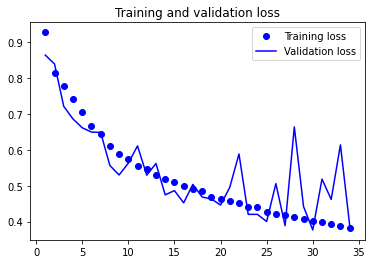

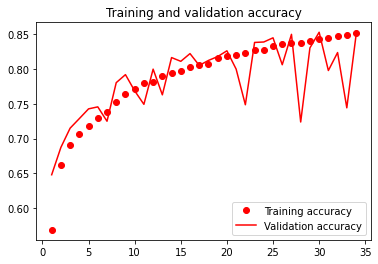

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
print(len(epochs), len(loss), len(val_loss))
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
plt.figure()
plt.plot(epochs, accuracy, "ro", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

This version appears to have yielded a slightly smaller final validation accuracy than the original